# Queries for OverpassAPI with overpy, shapely and requests

## geolocation by name, get IDnumber

NOTE: Search by area using relation or way id. First lookup OSM id in osm.org. The area id needs to be OSM id + 2400000000 for ways and OSM id + 3600000000 for relations. See https://wiki.osm.org/wiki/Overpass_API/Overpass_QL#By_area_.28area.29


In [ ]:
 !pip install overpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.0 MB/s 
  Created wheel for overpy: filename=overpy-0.6-py3-none-any.whl size=14106 sha256=e224b3f0afdf71678c4332fb5e90205f78623eb372daacccf2687f7f23325053
  Stored in directory: /root/.cache/pip/wheels/1a/d3/0e/090c6914956cc37881fc914101d2a952c0da8e66fc86dc6a31
Successfully built overpy


In [ ]:
from geopy.geocoders import Nominatim
import overpy

city_name = "Berlin"

# Geocoding request via Nominatim
geolocator = Nominatim(user_agent="city_compare")
geo_results = geolocator.geocode(city_name, exactly_one=False, limit=3)

# Searching for relation in result set
for r in geo_results:
    print(r.address, r.raw.get("osm_type"))
    if r.raw.get("osm_type") == "relation":
        city = r
        break


# Calculating area id
area_relid = int(city.raw.get("osm_id")) + 3600000000 #for features
area_wayid = int(city.raw.get("osm_id")) + 2400000000
area_osmid = int(city.raw.get("osm_id")) #for city
print(area_osmid)

Berlin, Deutschland relation
62422


## min max lon lat for city Requests

In [ ]:
import requests

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
                [out:json][timeout:25];
                rel({area_osmid});
                out geom;
                """
response = requests.get(overpass_url, 
                            params={'data': overpass_query})
res = response.json()

In [ ]:
res['elements'][0]['bounds']

{'maxlat': 52.6755087,
 'maxlon': 13.7611609,
 'minlat': 52.3382448,
 'minlon': 13.088345}

## City boundaries from Shapely

In [ ]:
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize


query = f"""[out:json][timeout:25];
rel({area_osmid});
out body;
>;
out skel qt; """
api = overpy.Overpass()
result = api.query(query)

lss = []  #convert ways to linstrings

for ii_w, way in enumerate(result.ways):
    ls_coords = []

    for node in way.nodes:
        ls_coords.append(
            (node.lon, node.lat))  # create a list of node coordinates

    lss.append(
        geometry.LineString(ls_coords))  # create a LineString from coords

merged = linemerge([*lss])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
city = geometry.MultiPolygon(polygons)

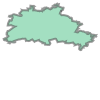

In [ ]:
city

In [ ]:
type(city)

shapely.geometry.multipolygon.MultiPolygon

### create geojson

In [ ]:
from shapely.geometry import mapping

gjson = mapping(city)

### save geojson

In [ ]:
from geojson import Point, Feature, FeatureCollection, dump

with open(f'{city_name}_boundaries.geojson', 'w') as f:
   dump(mapping(city), f)

ModuleNotFoundError: ignored

# Features

## function param string

### Dict for params

In [ ]:
keys_values_osm = {'amenity':['pub', 'cafe']}

In [ ]:
def param_nwr(keys):
    '''converts the dict into a string, returns a str'''
    osm_keys = ''
    for k,val in keys.items():
        for v in val:
            osm_keys += f"""nwr['{k}'='{v}'](area.bound);"""
    return osm_keys

In [ ]:
param_nwr(keys_values_osm)

"nwr['amenity'='pub'](area.bound);nwr['amenity'='cafe'](area.bound);"

## overpass call for features Overpy

In [ ]:
# Excecuting overpass call
api = overpy.Overpass()
result = api.query(f"""
    area(%s)->.bound;
    (
      {param_nwr(keys_values_osm)}
    );
    out center;
    """ % area_relid)

# Printing no. of pubs in nodes and ways
print("Amenities in nodes: %d" % len(result.nodes))
print("Amenities in ways: %d" % len(result.ways))
print("Amenities in areas: %d" % len(result.areas))

Amenities in nodes: 3253
Amenities in ways: 86
Amenities in areas: 0


In [ ]:
coords  = []
coords += [(float(node.lon), float(node.lat)) 
           for node in result.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in result.ways]
coords += [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in result.relations]


In [ ]:
coords

[(-0.5305164, 39.5660379),
 (-0.5316451, 39.5658829),
 (-0.5288542, 39.5776676),
 (-0.530182, 39.5664047)]

API Reference, test for speeding up, https://python-overpy.readthedocs.io/en/latest/api.html

api = overpy.Overpass()
api.parse_json(data)

overpy.result().parse_json(data)

## test with areas and polygons

In [ ]:
water = {'natural':['water','beach'],
         'amenity':['fountain']}

cycle = {'highway':['pedestrian','cycleway']}

green = {'landuse':['grass','forest','orchard','allotments','cementery','flowerbed', 'meadow','greenfield', 'recreation_ground','village_green'],
         'leisure':['park','playground','garden'],
         'natural':['heath','shrubbery','wood','grassland']}

In [ ]:
areas_osm = {'landuse':['village_green']}

https://python-overpy.readthedocs.io/en/latest/_modules/overpy.html
execution times

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.3 MB/s 
     |████████████████████████████████| 16.7 MB 253 kB/s 
     |████████████████████████████████| 6.3 MB 28.5 MB/s 


In [ ]:
# Excecuting overpass call
from geopandas import GeoDataFrame
api = overpy.Overpass()
s = GeoDataFrame.to_json(gjson)

api.parse_json(s)

result = api.query(f"""
    area(%s)->.bound;
    (
      {param_nwr(areas_osm)}
    );
    out center;
    """ % area_relid)

# Printing no. of pubs in nodes and ways
print("Amenities in nodes: %d" % len(result.nodes))
print("Amenities in ways: %d" % len(result.ways))
print("Amenities in areas: %d" % len(result.areas))

AttributeError: ignored

In [ ]:
lss = []  #convert ways to linstrings

for ii_w, way in enumerate(result.ways):
    ls_coords = []
    nodes = way.get_nodes(resolve_missing=True)
    
    for node in nodes:
        ls_coords.append(
            (node.lon, node.lat))  # create a list of node coordinates

    lss.append(
        geometry.LineString(ls_coords))  # create a LineString from coords

merged = linemerge([*lss])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [ ]:
parks = geometry.MultiPolygon(polygons)

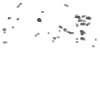

In [ ]:
parks

In [ ]:
import folium

In [ ]:
map_test = folium.Map(width=750,height=500,location=[res['elements'][0]['bounds']['maxlat'], res['elements'][0]['bounds']['maxlon'] ],tiles="openstreetmap",   zoom_start=15)
folium.GeoJson(mapping(parks)).add_to(map_test)

In [ ]:
map_test